# CNN

In [1]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [58]:
import os
import sys
import random
import warnings
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
import torch

from torch.utils import data
from skimage.transform import resize
from matplotlib import pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [16]:
class TGSSaltDataset(data.Dataset):
    
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        
        return image, mask

In [17]:
train_mask = pd.read_csv('../../tgs_data/train.csv')
train_path = "../../tgs_data/train/"

file_list = list(train_mask['id'].values)
dataset = TGSSaltDataset(train_path, file_list)

In [59]:
X_train = np.zeros((len(file_list), 128, 128, 1), dtype=np.uint8)
Y_train = np.zeros((len(file_list), 128, 128, 1), dtype=np.bool)

for n in range(len(file_list)):
    image, mask = dataset.__getitem__(n)
    X_train[n] = resize(image[:, :, 1], (128, 128, 1), mode='constant', preserve_range=True)
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

#image, mask = dataset.__getitem__(1)

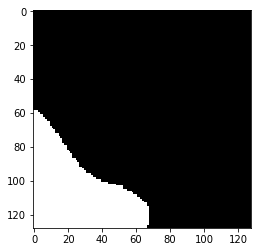

In [60]:
# Check if training data looks all right
ix=3

tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [52]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    
    return K.mean(K.stack(prec), axis=0)

In [63]:
# Build U-Net model
inputs = Input((128, 128, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
lambda_8 (Lambda)                (None, 128, 128, 1)   0           input_8[0][0]                    
____________________________________________________________________________________________________
conv2d_88 (Conv2D)               (None, 128, 128, 8)   80          lambda_8[0][0]                   
____________________________________________________________________________________________________
conv2d_89 (Conv2D)               (None, 128, 128, 8)   584         conv2d_88[0][0]                  
___________________________________________________________________________________________

In [66]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=0, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/10
3600/3600 [==============================] - 254s - loss: 0.4988 - mean_iou: 0.3872 - val_loss: 0.4224 - val_mean_iou: 0.3896
Epoch 2/10
3600/3600 [==============================] - 280s - loss: 0.4041 - mean_iou: 0.4056 - val_loss: 0.3964 - val_mean_iou: 0.4282
Epoch 3/10
3600/3600 [==============================] - 285s - loss: 0.3699 - mean_iou: 0.4440 - val_loss: 0.3605 - val_mean_iou: 0.4604
Epoch 4/10
3600/3600 [==============================] - 300s - loss: 0.3485 - mean_iou: 0.4747 - val_loss: 0.3289 - val_mean_iou: 0.4861
Epoch 5/10
3600/3600 [==============================] - 295s - loss: 0.3317 - mean_iou: 0.4972 - val_loss: 0.3133 - val_mean_iou: 0.5074
Epoch 6/10
3600/3600 [==============================] - 301s - loss: 0.3175 - mean_iou: 0.5173 - val_loss: 0.2842 - val_mean_iou: 0.5269
Epoch 7/10
3600/3600 [==============================] - 300s - loss: 0.3019 - mean_iou: 0.5365 - val_loss: 0.2773 - val_mean_iou: 0